# Projet 07 : Effectuer une prédiction de revenus

---
**Importation des librairies**

In [1]:
#import warnings
#warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as plc
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
import modules_perso.sf_graphiques as sfg

---
## <font color=blue>Mission 4 : Modélisation du revenu des individus</font>

### 4.5.b ANOVA du logarithme du revenu basée sur le seul logarithme du revenu moyen

In [4]:
data = pd.read_csv("data_analyse04.csv", index_col=0)
data.head()

C:\Anaconda3\envs\Jupyter\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ln_child_income,ln_revenu_moyen,gini_from_centiles
0,6.591534,8.004643,32.141019
1,6.591534,8.004643,32.141019
2,6.591534,8.004643,32.141019
3,6.591534,8.004643,32.141019
4,6.591534,8.004643,32.141019


In [5]:
anova = smf.ols(formula="ln_child_income ~ ln_revenu_moyen", data=data).fit()

In [6]:
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_child_income   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                 1.437e+07
Date:                Mon, 14 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:50:57   Log-Likelihood:            -6.2689e+06
No. Observations:             5642420   AIC:                         1.254e+07
Df Residuals:                 5642418   BIC:                         1.254e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.4512      0.002   -203.647      0.000      -0.456      -0.447
ln_revenu_moyen     1.0224      0.000   3790.979      0.000       1.022       1.023
==============================================================================
Omnibus:                   498673.735   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1926216.994
Skew:                          -0.390   Prob(JB):                         0.00
Kurtosis:                       5.754   Cond. No.                         59.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
ln_revenu_moyen,7.763607e+06,1.0,1.437152e+07,0.0,0.718076,0.718075
Residual,3.048078e+06,5642418.0,NaN,NaN,NaN,NaN
total,1.081168e+07,5642419.0,NaN,NaN,NaN,NaN


La part de dispersion expliquée par le modèle (R²) baisse légèrement à 71,8% par rapport au modèle 4 de base. On remarque également que les scores AIC et BIC augmentent légèrement, ce qui traduit une dégradation de la qualité prédictive de la modélisation.  
La variable ln_revenu_moyen est logiquement significative.

### Vérification des hypothèses

**Hypothèse 1 : Normalité des résidus**

In [8]:
alpha_normalite = 0.05
ad_stat, ad_pvalue = sm.stats.normal_ad(anova.resid)
norm_stat, norm_pvalue = st.kstest(anova.resid, cdf='norm', args=(anova.resid.mean(), anova.resid.var(ddof=1)))
jb_stat, jb_pvalue, skw, kurt = sm.stats.stattools.jarque_bera(anova.resid)
df_normalite = pd.DataFrame({'H0':np.repeat("Distribution normale",3), 'Statistique':["{:.2f}".format(ad_stat),"{:.2f}".format(norm_stat),"{:.2f}".format(jb_stat)], \
                             'p-value':["{:.3f}".format(ad_pvalue),"{:.3f}".format(norm_pvalue),"{:.3f}".format(jb_pvalue)]}, index=["Anderson-Darling","Kolmogorov-Smirnov","Jarque-Bera"])
inter_col = "Résultat (seuil={:.1%})".format(alpha_normalite)
df_normalite[inter_col] = ["Normalité acceptée" if float(pval)>=alpha_normalite else "Normalité rejetée" for pval in df_normalite["p-value"]]
df_normalite

C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


,H0,Statistique,p-value,Résultat (seuil=5.0%)
Anderson-Darling,Distribution normale,22118.13,0.000,Normalité rejetée
Kolmogorov-Smirnov,Distribution normale,0.05,0.000,Normalité rejetée
Jarque-Bera,Distribution normale,1926216.99,0.000,Normalité rejetée


Aucun des trois test n'accepte la normalité. Nous avons un grand nombre d'observations. Une symétrie de la distribution des résidus sera suffisante. Je vérifie graphiquement cette symétrie, et je trace également la droite de Henry.

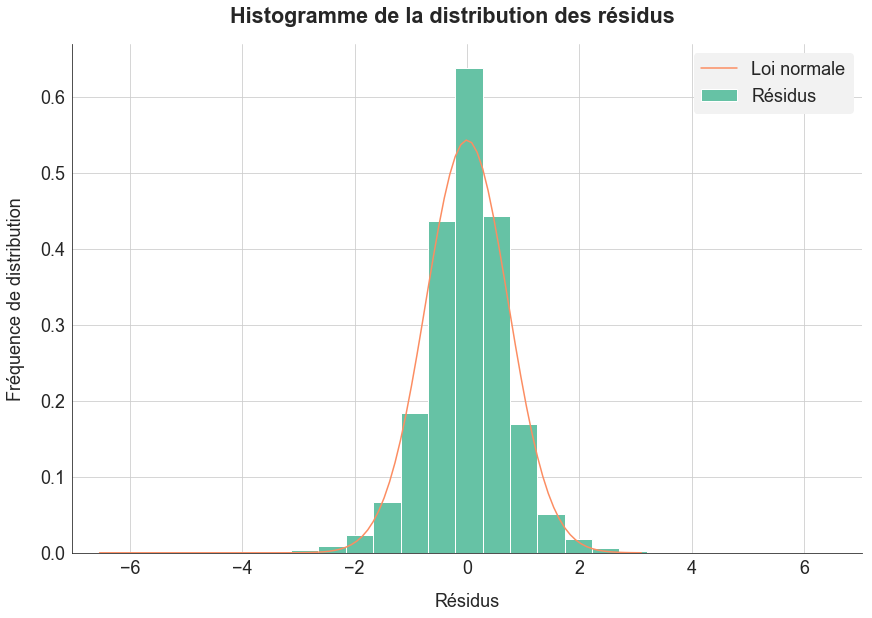

In [9]:
x_theo = np.arange(anova.resid.min(), anova.resid.max(), 0.01*(anova.resid.max()-anova.resid.min()))
mygraph = sfg.MyGraph("Histogramme de la distribution des résidus", is_mono=False)
mygraph.add_histogramme(anova.resid, bins=20, labels="Résidus")
mygraph.add_plot(x_theo, st.norm.pdf(x_theo, scale=anova.resid.std(ddof=1)), label="Loi normale", legend=True)
xmin, xmax = mygraph.ax[0].get_xlim()
absmax = max(-xmin, xmax)
mygraph.set_axe('y', label="Fréquence de distribution")
mygraph.set_axe('x', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04b_01_distribution_residus.png")
plt.show()

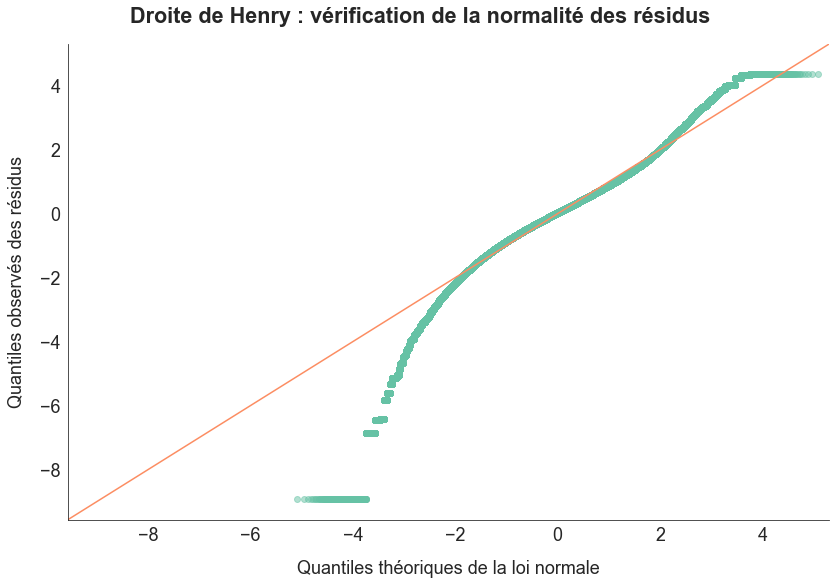

In [10]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04b_02_droite_henry.png")
plt.show()

L'abandon de l'indice de Gini n'améliore pas de manière notable la normalité de la distribution des résidus.

**Hypothèse 2 : Linéarité et additivité de la relation  
Hypothèse 3 : Homoscédasticité des résidus**

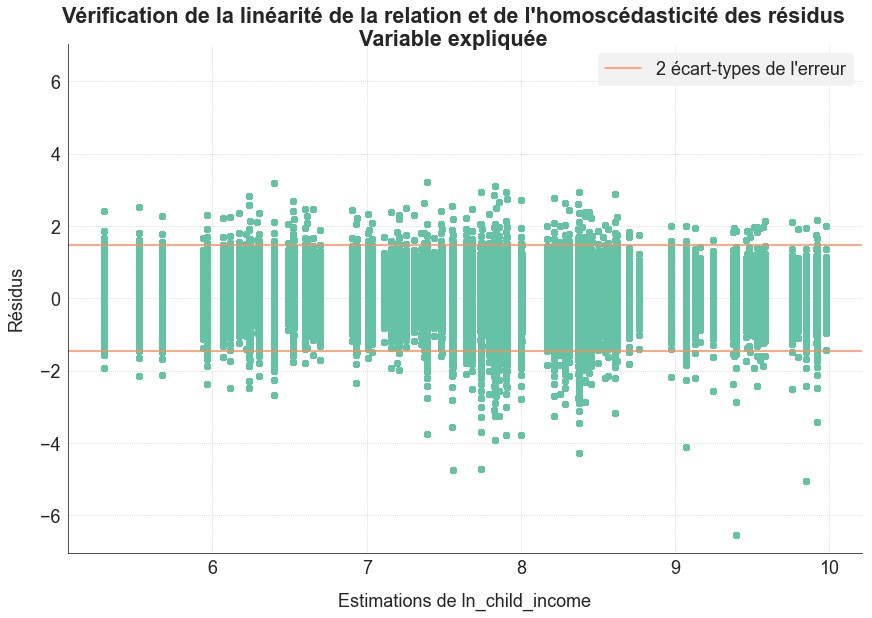

In [11]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation et de l'homoscédasticité des résidus\nVariable expliquée", is_mono=False)
mygraph.add_plot(anova.fittedvalues, anova.resid, label="", marker='o', linestyle='', with_grid='both', grid_style=":")
yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1])
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Estimations de ln_child_income")
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04b_03_linearite_homoscedasticite_endo.png")
plt.show()

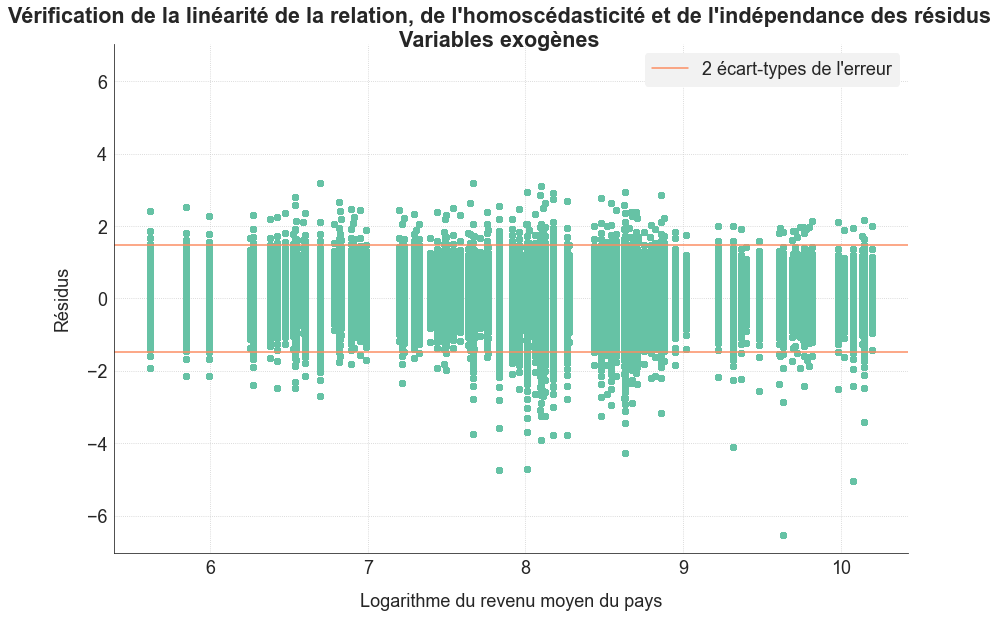

In [12]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation, de l'homoscédasticité et de l'indépendance des résidus\nVariables exogènes", is_mono=False)
mygraph.add_plot(data.ln_revenu_moyen, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[0], linestyle='', with_grid='both', grid_style=":")
#yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1])
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Logarithme du revenu moyen du pays")
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04b_04_linearite_homoscedasticite_exo.png")
plt.show()

In [13]:
alpha_homo = 0.05
lm_stat, lm_pvalue, f_stat, f_pvalue = sm.stats.diagnostic.het_breuschpagan(anova.resid, anova.model.exog)
if f_pvalue >= alpha_homo:
    test_result = ["Homoscédasticité acceptée"]
else:
    test_result = ["Homoscédasticité rejetée"]
pd.DataFrame({'H0':["Variance des résidus constante"], 'Statistique':["{:.2f}".format(f_stat)], \
             'p-value':["{:.3f}".format(f_pvalue)], 'Résultat (seuil={:.1%})'.format(alpha_homo):test_result}, index=["Breusch Pagan"])

,H0,Statistique,p-value,Résultat (seuil=5.0%)
Breusch Pagan,Variance des résidus constante,2299.38,0.000,Homoscédasticité rejetée


L'homoscédasticité est toujours rejetée par le test. Par contre, les graphiques restent similaires à ceux obtenus auparavant. Ils montrent que les résidus sont désormais assez bien répartis dans les valeurs positives et négatives. Les graphiques sont satisfaisants et permettent de valider les hypothèses d'homoscédasticité des résidus et de linéarité de la relation générale.

**Conclusion sur les hypothèses**

Les graphiques permettent d'accepter les 3 hypothèses.

**Vérification supplémentaire : absence de colinéarité entre les exogènes**

Une seule variable : pas de problème de colinéarité.

**Vérification de la pertinence des estimations par rapport aux valeurs réelles**

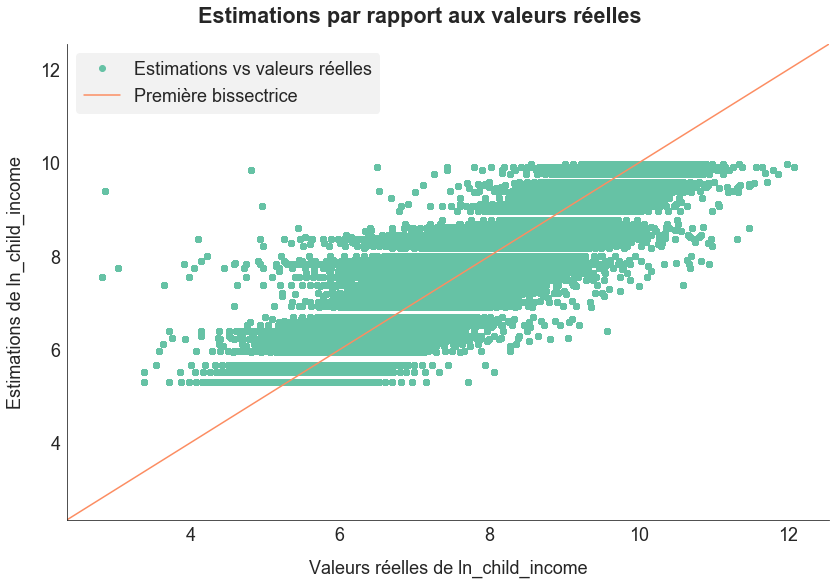

In [14]:
mygraph = sfg.MyGraph("Estimations par rapport aux valeurs réelles", is_mono=False)
mygraph.add_plot(data.ln_child_income, anova.fittedvalues, label="Estimations vs valeurs réelles", marker='o', linestyle="")
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="Première bissectrice", legend=True)
mygraph.set_axe('y', label="Estimations de ln_child_income")
mygraph.set_axe('x', label="Valeurs réelles de ln_child_income")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04b_06_accuracy_graph.png")
plt.show()

**Analyse des outliers**

In [15]:
n, p = anova.model.exog.shape
p = p - 1  # j'enlève la constante du nombre de paramètres pour ajuster les seuils
seuils = pd.Series(index=["levier", "resid_student", "dffits", "cook","dfbetas"])
seuils.levier = 2 * (p + 1) / n
seuils.dffits = 2 * np.sqrt((p + 1) / n)
seuils.cook = 4 / (n - p - 1)
seuils.resid_student = st.t.ppf(1-(0.05/2), n-p-2)  # seuil de 5% pour les résidus studentisés
reg_influence = anova.get_influence()
analyses = pd.DataFrame({"observation_name":data.index})
analyses["levier"] = reg_influence.hat_matrix_diag
#analyses["external_resid_student"] = reg_influence.resid_studentized_external
#analyses["outlier"] = ((analyses.levier > seuils.levier) | (abs(analyses.external_resid_student) > seuils.resid_student))
analyses["outlier"] = analyses.levier > seuils.levier
#analyses["dffits"] = reg_influence.dffits[0]
analyses["cook_distance"] = reg_influence.cooks_distance[0]
analyses["influence"] = analyses.cook_distance > seuils.cook
#analyses["influence"] = (abs(analyses.dffits) > seuils.dffits) | (analyses.cook_distance > seuils.cook)

In [16]:
seuils[["levier","cook"]].to_frame().style.format("{:.8f}")

,0
levier,0.00000071
cook,0.00000071


In [17]:
only_both = False
if only_both == False:
    print("Résumé des observations atypiques OU influentes")
    variables_speciales = analyses[(analyses.outlier | analyses.influence) & (analyses.outlier != analyses.influence)]
    print(variables_speciales)
    print("")
print("Résumé des observations atypiques ET influentes")
variables_investigation = analyses[analyses.outlier & analyses.influence]
variables_investigation

Résumé des observations atypiques OU influentes
         observation_name        levier  outlier  cook_distance  influence
49843               49843  2.162447e-07    False   1.659287e-06       True
49844               49844  2.162447e-07    False   1.659287e-06       True
49845               49845  2.162447e-07    False   1.659287e-06       True
49846               49846  2.162447e-07    False   1.659287e-06       True
49847               49847  2.162447e-07    False   1.659287e-06       True
49848               49848  2.162447e-07    False   1.659287e-06       True
49849               49849  2.162447e-07    False   1.659287e-06       True
49850               49850  2.162447e-07    False   1.659287e-06       True
49851               49851  2.162447e-07    False   1.659287e-06       True
49852               49852  2.162447e-07    False   1.659287e-06       True
49853               49853  2.162447e-07    False   1.659287e-06       True
49854               49854  2.162447e-07    False   1

,observation_name,levier,outlier,cook_distance,influence
898552,898552,7.964271e-07,True,0.000003,True
898553,898553,7.964271e-07,True,0.000003,True
898554,898554,7.964271e-07,True,0.000003,True
898555,898555,7.964271e-07,True,0.000003,True
898556,898556,7.964271e-07,True,0.000003,True
898557,898557,7.964271e-07,True,0.000003,True
898558,898558,7.964271e-07,True,0.000003,True
898559,898559,7.964271e-07,True,0.000003,True
898560,898560,7.964271e-07,True,0.000003,True
898561,898561,7.964271e-07,True,0.000003,True


Le nombre d'obervations soit atypiques soit influentes (mais pas à la fois atypiques et influentes) augmente sensiblement par rapport au modèle 4 initial (456 169 observations contre 316 082), avec notamment l'apparition d'observations atypiques.
Le nombre d'obervations à la fois atypiques et influentes diminue légèrement de 52 311 observations à 47 215 observations.

**Conclusion sur cette variante**

Je pense qu'il ne faut pas supprimer l'indice de Gini du modèle. En effet, cette suppression détériore un peu la qualité du modèle et augmente le nombre de points atypiques. La relative augmentation des résidus avec le niveau de l'indice de Gini est tout à fait logique et s'explique parfaitement. Je ne la considère pas génante.